In [6]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

from tqdm import tqdm
from math import sqrt,erf
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import numpy as np
from varname import nameof
from itertools import product
from matplotlib.cm import get_cmap
import colorcet as cc
import subprocess
import os, shutil
from time import time
import functools
from scipy import special
import scipy
from IPython.display import display, clear_output
import fermionise as fermionise
import eigenstateRG as eigRG



plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 15,
                     'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "black",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 35,
                    })
linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", facecolor="lightgray")

D0 = 1
deltaD = 0.001
plt.plot([], [])
plt.show()
clear_output()

In [7]:
def get_RG_flow(J0_by_D0, Ub_by_J=0, plot=False):
    """ Returns the flow of couplings in the form of two ndarrays J and D.
    Each ndarray is in ascending order of the bandwidth. """
    J0 = D0 * J0_by_D0
    Ub = - Ub_by_J * J0
    omega = -D0/2
    
    ### initialise arrays with UV values
    D = [D0]
    J = [J0]
    
    ### apply URG transformations until bandwith vanishes
    ### or J reduces to zero.
    while D[-1] >= deltaD and J[-1] >= 0:
        
        ### URG equation
        deltaJ = - J[-1] * (J[-1] + 4 * Ub) / (omega - D[-1]/2 + J[-1]/4) * deltaD
        
        ### Check if denominator has changed sign, 
        ### then append renormalised values to array
        if (omega - (D[-1] - deltaD)/2 + (J[-1] + deltaJ)/4) * (omega - D0/2 + J0/4) > 0:
            D.append(D[-1] - deltaD)
            J.append(J[-1] + deltaJ)
        else:
            break
    
    ### plot values
    if plot:
        plt.plot(np.array(D)/D0, np.array(J)/J0, marker="o")
        plt.xlabel(r"$D/D_0$")
        plt.ylabel(r"$J/J_0$")
    return np.flip(D), np.flip(J)

In [8]:
def KondoMERG(J0_by_D0, num_entangled, num_IOMs):
    D, J = get_RG_flow(J0_by_D0)
    omega = -D0/2
    Ek = np.linspace(deltaD, D[0], num_entangled)
    alpha_arr = [Ji / (2 * (omega - Di/2 + Ji/4)) for Ji, Di in zip(J, D)][:num_IOMs]
    init_couplings = [Ek, J[0], 0]
    decomposition_arr = eigRG.getWavefunctionRG(init_couplings, alpha_arr, num_entangled, num_IOMs, 
                                                fermionise.getKondoHamiltonian, eigRG.getEtaKondo, 
                                              )
    computation_results = eigRG.computations(decomposition_arr,
                                            {"VNE": [2, 3],
                                            }
                                           )
    return num_entangled, num_IOMs, computation_results

Expressing state in terms of basis.: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44413.54it/s]

[-0.08661899  0.        ]
G-state energy: [-0.08661899]
↓|↑		↑|↓
0.707		-0.707



Computing VNE: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1299.95it/s]


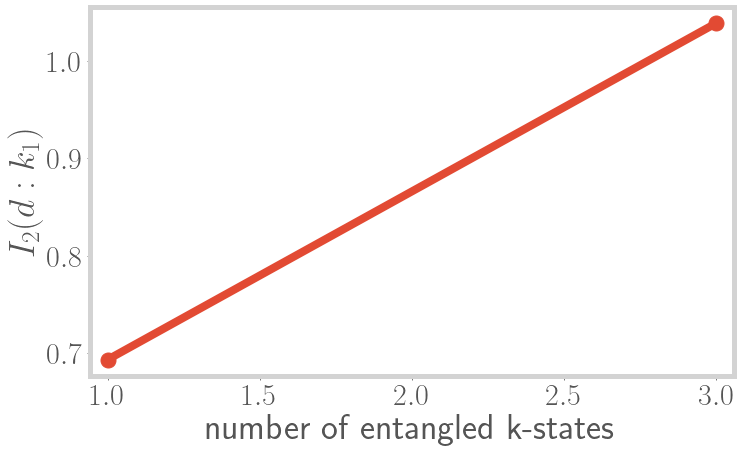

In [9]:
num_entangled, num_IOMs, computation_results = KondoMERG(0.1, 1, 1)
plt.plot(range(num_entangled, num_entangled + 2 * num_IOMs + 1, 2), computation_results["VNE"], marker='o')
plt.ylabel(r"$I_2(d:k_1)$")
plt.xlabel("number of entangled k-states")
plt.show()